## TUTORIAL 02 - Elastic block problem
**_Keywords: POD-Galerkin method, vector problem_**

### 1. Introduction
In this Tutorial we consider a linear elasticity problem in a two-dimensional square domain $\Omega$.

The domain is partioned in nine square subdomains, as in the following figure

<img src="https://github.com/RBniCS/RBniCS/raw/master/tutorials/02_elastic_block/data/elastic_block.png" width="35%" />

Parameters of this problem include Young moduli of each subdomain, as well as lateral traction on the right side of square. In particular:
* the ratio between the Young modulus of the each subdomain $\Omega_{p+1}$, $p=0,\dots,7$ and the top-right subdomain $\Omega_9$ is denoted by $\mu_p$, being

$$
\mu_p \in \left[1, 100\right] \qquad \text{for }p=0,\dots,7.
$$

* the horizontal tractions on each boundary $\Gamma_{p-6}$, $p=8,\dots,10$, being

$$
\mu_p \in \left[-1,1\right] \qquad \text{for } p=8,\dots, 10.
$$

For what concerns the remaining boundaries, the left boundary $\Gamma_6$ is clamped, while the top and bottom boundaries $\Gamma_1 \cup \Gamma_5$ are traction free.

The parameter vector $\boldsymbol{\mu}$ is thus given by
$$
\boldsymbol{\mu} = (\mu_0, \cdots,\mu_{10})
$$
on the parameter domain
$$
\mathbb{P}=[1,100]^8\times[-1,1]^3.
$$

In order to obtain a faster approximation of the problem we pursue a model reduction by means of a POD-Galerkin reduced order method.

In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh";
    import dolfin

--2025-04-02 15:49:30--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0.001s  

2025-04-02 15:49:30 (7.86 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1f33a7ab/releases/pybi

In [ ]:
# Install RBniCS
try:
    import rbnics
except ImportError:
    !pip3 install git+https://github.com/RBniCS/RBniCS.git
    import rbnics
import rbnics.utils.config
assert "dolfin" in rbnics.utils.config.config.get("backends", "required backends")

  Cloning https://github.com/RBniCS/RBniCS.git to /tmp/pip-req-build-f22wja38
  Running command git clone --filter=blob:none --quiet https://github.com/RBniCS/RBniCS.git /tmp/pip-req-build-f22wja38
  Resolved https://github.com/RBniCS/RBniCS.git to commit b23d20d68d22579c0995b16025f7f1e858d65259
  Preparing metadata (setup.py) ... done
  Created wheel for RBniCS: filename=RBniCS-0.2.0-py3-none-any.whl size=598339 sha256=4a07d8208c642015f7685c9299f2752d67bbfbcdcebd073b9dd5d45beae048b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-pmv80w2o/wheels/91/6e/53/8e8074380bbeb5ca55786b492fcb71afa192955accca0a7cea
Successfully built RBniCS


# Observación
Puede ser que el texto debajo no ande en un principio (si se ejecuta en 0 segundos no anda, va a aparecer algo como "no such file directory"). Si pasa eso probar ejecutar la sección 4.1 que no va a andar, y después ejecutar esto

### 2. Parametrized formulation

Let $\boldsymbol{u}(\boldsymbol{\mu})$ be the displacement in the domain $\Omega$.

In each subdomain $\Omega_{p+1}$, $p=0,\dots,7$, we assume an isotropic linear elastic material, characterized by the following Lamè constants for plane strain
$$\lambda_1(\mu_p) = \frac{\mu_p \nu}{(1+\nu)(1-2\nu)},$$
$$\lambda_2(\mu_p) = \frac{\mu_p}{2(1+\nu)},$$
for $\nu=0.30$, with the following Piola-Kirchhoff tensor

$$
\boldsymbol{\pi}(\boldsymbol{u}; \mu_p) =
\lambda_1(\mu_p)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\; \boldsymbol{I} +
2\;\lambda_2(\mu_p)\;\nabla_{S}\boldsymbol{u}
$$
where $\nabla_{S}$ denotes the symmetric part of the gradient.

Similarly, the Piola-Kirchhoff tensor in the top right subdomain $\Omega_9$ is given by $\boldsymbol{\pi}(\boldsymbol{u}; 1)$.

Thus, the Piola-Kirchhoff tensor on the domain $\Omega$ can be obtained as
$$
\boldsymbol{P}(\boldsymbol{u}; \boldsymbol{\mu}) =
\Lambda_1(\boldsymbol{\mu})\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\; \boldsymbol{I} +
2\;\Lambda_2(\boldsymbol{\mu})\;\nabla_{S}\boldsymbol{u}
$$
where
$$
\Lambda_1(\boldsymbol{\mu}) = \sum_{p=0}^{7} \lambda_1(\mu_p) \mathbb{1}_{\Omega_{p+1}} + \lambda_1(1) \mathbb{1}_{\Omega_{9}}
$$
$$
\Lambda_2(\boldsymbol{\mu}) = \sum_{p=0}^{7} \lambda_2(\mu_p) \mathbb{1}_{\Omega_{p+1}} + \lambda_2(1) \mathbb{1}_{\Omega_{9}}
$$

The strong formulation of the parametrized problem is given by:
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $\boldsymbol{u}(\boldsymbol{\mu})$ such that</center>
$$
\begin{cases}
	- \text{div} \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
    \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mathbf{0} & \text{on } \Gamma_{1},\\
	\boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mu_p \mathbf{n} & \text{on } \Gamma_{p-6}, p=8,\dots, 10,\\
    \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mathbf{0} & \text{on } \Gamma_{5},\\
	\boldsymbol{u}(\boldsymbol{\mu}) = \boldsymbol{0} & \text{on } \Gamma_{6},\\
\end{cases}
$$
<br>

where $\mathbf{n}$ denotes the outer normal to the boundary $\partial\Omega$.

The corresponding weak formulation reads:
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that</center>

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{\boldsymbol{v}\in H^1(\Omega; \mathbb{R}^2) : \boldsymbol{v}|_{\Gamma_{6}}=\boldsymbol{0}\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(\boldsymbol{u}, \boldsymbol{v}; \boldsymbol{\mu})=\int_{\Omega}
\left\{
\Lambda_1(\boldsymbol{\mu})\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\Lambda_2(\boldsymbol{\mu})\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v}
\right\}  d\boldsymbol{x}
$$,
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(\boldsymbol{v}; \boldsymbol{\mu})= \sum_{p=8}^{10} \mu_p \int_{\Gamma_{p-6}} \boldsymbol{v} \cdot \mathbf{n} \ ds$$.

In [ ]:
#Importa las bibliotecas necesarias
from dolfin import *
from rbnics import *
import numpy as np

## 3. Affine decomposition

For this problem the affine decomposition is straightforward. Indeed, owing to the definitions of $\Lambda_1(\boldsymbol{\mu})$ and $\Lambda_2(\boldsymbol{\mu})$, we have:
$$
a(\boldsymbol{u}, \boldsymbol{v}; \boldsymbol{\mu}) = \sum_{p=0}^7 \underbrace{\mu_{\color{red} p}}_{\Theta^{a}_{\color{red} p}(\boldsymbol{\mu})} \underbrace{\int_{\Omega_{\color{red}{p + 1}}}
\left\{\lambda_1(1)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\lambda_2(1)\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v} \right\}  d\boldsymbol{x}}_{a_{\color{red} p}(\boldsymbol{u}, \boldsymbol{v})} +\\
\underbrace{1}_{\Theta^{a}_{\color{red} 8}(\boldsymbol{\mu})} \underbrace{\int_{\Omega_{\color{red} 9}}
\left\{\lambda_1(1)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\lambda_2(1)\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v} \right\}  d\boldsymbol{x}}_{a_{\color{red} 8}(\boldsymbol{u}, \boldsymbol{v})}\\
$$
$$
f(\boldsymbol{v}; \boldsymbol{\mu}) =
\sum_{p=8}^{10} \underbrace{\mu_{\color{red} p}}_{\Theta^{f}_{\color{red}{p-8}}(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{\color{red}{p-6}}} \boldsymbol{v} \cdot \mathbf{n}}_{f_{\color{red}{p-8}}(\boldsymbol{v})}.
$$

We will implement the numerical discretization of the problem in the class
```
class ElasticBlock(EllipticCoerciveProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(\boldsymbol{u}, \boldsymbol{v})$ and linear forms $f_*(\boldsymbol{v})$ in
```
    def assemble_operator(self, term):
```

In [ ]:
class ElasticBlock(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V) #u funcion que queremos obtener
        self.v = TestFunction(V) #v función auxiliar
        self.dx = Measure("dx")(subdomain_data=self.subdomains) #dx es para integrar en el dominio completo
        self.ds = Measure("ds")(subdomain_data=self.boundaries) #ds es para integrar solo en el borde del dominio
        # ...
        self.f = Constant((1.0, 0.0))
        self.E = 1.0 #Esto es mu_p (vendría a ser el valor de la densidad de el subloque 9?)
        self.nu = 0.3
        self.lambda_1 = self.E * self.nu / ((1.0 + self.nu) * (1.0 - 2.0 * self.nu))
        self.lambda_2 = self.E / (2.0 * (1.0 + self.nu))

    # Return custom problem name
    def name(self):
        return "ElasticBlock" #No se cual sería el objetivo de esta linea, supongo que se podrá evitar este método

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = mu[1]
            theta_a2 = mu[2]
            theta_a3 = mu[3]
            theta_a4 = mu[4]
            theta_a5 = mu[5]
            theta_a6 = mu[6]
            theta_a7 = mu[7]
            theta_a8 = 1. #En realidad parece que aca fija el valor de mu para el bloque 9, entonces que hace esa E
            return (theta_a0, theta_a1, theta_a2, theta_a3, theta_a4, theta_a5, theta_a6, theta_a7, theta_a8)
        elif term == "f":
            theta_f0 = mu[8]
            theta_f1 = mu[9]
            theta_f2 = mu[10]
            return (theta_f0, theta_f1, theta_f2)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = self.elasticity(u, v) * dx(1) #El a_p de la parte de descomposición afin de la ecuación
            a1 = self.elasticity(u, v) * dx(2)
            a2 = self.elasticity(u, v) * dx(3)
            a3 = self.elasticity(u, v) * dx(4)
            a4 = self.elasticity(u, v) * dx(5)
            a5 = self.elasticity(u, v) * dx(6)
            a6 = self.elasticity(u, v) * dx(7)
            a7 = self.elasticity(u, v) * dx(8)
            a8 = self.elasticity(u, v) * dx(9)
            return (a0, a1, a2, a3, a4, a5, a6, a7, a8)
        elif term == "f":
            ds = self.ds
            f = self.f
            f0 = inner(f, v) * ds(2)
            f1 = inner(f, v) * ds(3)
            f2 = inner(f, v) * ds(4)
            return (f0, f1, f2)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant((0.0, 0.0)), self.boundaries, 6)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(u, v) * dx + inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

    # Auxiliary function to compute the elasticity bilinear form
    def elasticity(self, u, v):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        return 2.0 * lambda_2 * inner(sym(grad(u)), sym(grad(v))) + lambda_1 * tr(sym(grad(u))) * tr(sym(grad(v)))

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](https://colab.research.google.com/github/RBniCS/RBniCS/blob/open-in-colab/tutorials/02_elastic_block/data/generate_mesh.ipynb
) notebook.

In [ ]:
# Download data files
!mkdir -p dataii
![ -f data/elastic_block.xml ] || wget https://github.com/RBniCS/RBniCS/raw/master/tutorials/02_elastic_block/data/elastic_block.xml -O data/elastic_block.xml #Datos de la malla
![ -f data/elastic_block_facet_region.xml ] || wget https://github.com/RBniCS/RBniCS/raw/master/tutorials/02_elastic_block/data/elastic_block_facet_region.xml -O data/elastic_block_facet_region.xml
![ -f data/elastic_block_physical_region.xml ] || wget https://github.com/RBniCS/RBniCS/raw/master/tutorials/02_elastic_block/data/elastic_block_physical_region.xml -O data/elastic_block_physical_region.xml

--2025-03-31 12:14:57--  https://github.com/RBniCS/RBniCS/raw/master/tutorials/02_elastic_block/data/elastic_block.xml
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/RBniCS/RBniCS/master/tutorials/02_elastic_block/data/elastic_block.xml [following]
--2025-03-31 12:14:57--  https://raw.githubusercontent.com/RBniCS/RBniCS/master/tutorials/02_elastic_block/data/elastic_block.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420977 (411K) [text/plain]
Saving to: ‘data/elastic_block.xml’

data/elastic_block. 100%[===================>] 411.11K  --.-KB/s    in 0.05s   

2025-03-31 12:14:57 (8.85 MB/

In [ ]:
mesh = Mesh("data/elastic_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/elastic_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/elastic_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [ ]:
V = VectorFunctionSpace(mesh, "Lagrange", 1) #Grado de la interpolación

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00242424 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.242052 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00193667 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0122957 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

### 4.3. Allocate an object of the ElasticBlock class

In [ ]:
#Fijo las primeras 8 variables de mu a 1 asi la constante elastica de todo el bloque es uniforme
problem = ElasticBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [
    (1.0, 1.0),
    (1.0, 1.0),
    (1.0, 1.0),
    (1.0, 1.0),
    (1.0, 1.0),
    (1.0, 1.0),
    (1.0, 1.0),
    (1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.0)
]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [ ]:
reduction_method = PODGalerkin(problem) #Escoje el metodo de reducción
reduction_method.set_Nmax(10) #El máximo de la base
reduction_method.set_tolerance(0.000000001) #La tolerancia a la cual para de agregar elementos a la base

### 4.5. Perform the offline phase

In [ ]:
reduction_method.initialize_training_set(150) #Discretiza de alguna forma los valores de mu
reduced_problem = reduction_method.offline()
"""
Sobre la DISCRETIZACIÓN. La discretización es aleatoria si es por defecto. Para cada uno de los intervalos sortea con una variable uniforme el valor que toma
class UniformDistribution(Distribution):
    def sample(self, box, n):
        set_ = list()  # of tuples
        for i in range(n):
            mu = list()  # of numbers
            for box_p in box:
                mu.append(random.uniform(box_p[0], box_p[1]))
            set_.append(tuple(mu))
        return set_

  box seía el conjunto a discretizar y n la cantidad de puntos a discretizar
"""

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_36472edbcff073f6d8205a650c68e33d535e3540

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 2
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.051183 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_c8200760ff7ba9a9e86a2b7f8555ff38fb61d8ec

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0025835 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0083673 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3142d14591a69ae8a843853a55af6e9149fc9f3e

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00387359 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0112045 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_5dfbb7d6385c0bc8c968e61fc70db68456ade8e7

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00401425 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0101089 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e5ca5135f1577fb4c4ee347ae053de432af29143

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 3
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0228055 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_04e562af58e647e43d6db02eff1c6919d87e2ac7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 4
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0223019 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_521e410298d207b6f59d36aca5f621eb95b86847

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 5
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0294378 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e303f03b5ca15708573d9b47d374806254c281cd

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 6
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0227072 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9e2ab2ee164f8ef7bd254be02ebc8d2adf5607d7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 7
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0226839 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d0a7f4c4947bce540375ed4801bb3529861014ae

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 8
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.022017 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_1a47c7641a0a1cafa6e5924ca99ae46e222f49ab

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 9
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.022804 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9ec0f1d47df96fd11dc2effa172a9b5004c5547a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 10
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0311952 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:--------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a847fc3bf51dd564dff065b95d82ef8f4eedb70b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of exterior_facet subdomains: 3
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              1
  Coefficients:                        '[f_16]'
  Unique elements:                     'Vector<2 x CG1(?,?)>, Vector<2 x R0(?,?)>'
  Unique sub elements:                 'Vector<2 x CG1(?,?)>, Vector<2 x R0(?,?)>, C
                                       G1(?,?), R0(?,?)'
  

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_57b2d046702a951357e83418ce8e636842a8edc4

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00422168 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0120361 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4fe63847645198f4fe621846b110deff2200b6db

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00260234 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00998378 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representat

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_1b323ed8a22e3731f19c6f2159f9b38558674437

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of exterior_facet subdomains: 4
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              1
  Coefficients:                        '[f_16]'
  Unique elements:                     'Vector<2 x CG1(?,?)>, Vector<2 x R0(?,?)>'
  Unique sub elements:                 'Vector<2 x CG1(?,?)>, Vector<2 x R0(?,?)>, C
                                       G1(?,?), R0(?,?)'
  

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_8932ea55b026294ca4657506a19e7724ee07aabf

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of exterior_facet subdomains: 5
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              1
  Coefficients:                        '[f_16]'
  Unique elements:                     'Vector<2 x CG1(?,?)>, Vector<2 x R0(?,?)>'
  Unique sub elements:                 'Vector<2 x CG1(?,?)>, Vector<2 x R0(?,?)>, C
                                       G1(?,?), R0(?,?)'
  

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5bb75954c878c8bd6617f0c6a39d82e754ba3bd4

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0176854 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6c956765cd4f44f6742b288d7b0f040b8aae721a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0229611 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5911cdcd10f47ff444aa54b7d80a355ddc4dbfb6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_67]'
  Unique elements:           'Vector<2 x CG1(?,?)>, Vector<2 x R0(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, Vector<2 x R0(?,?)>, CG1(?,?), R
                             0(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> defa

=           ElasticBlock POD-Galerkin offline phase begins           =

################################# 0 ##################################
truth solve for mu = (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.19216774435842265, 0.04287070973699092, -0.1749565383263687)
update snapshots matrix

################################# 1 ##################################
truth solve for mu = (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.10085067278916471, -0.8291821974135369, 0.23335566618804449)
update snapshots matrix

################################# 2 ##################################
truth solve for mu = (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.41851568129337546, -0.19659644325677572, 0.24522754770753785)
update snapshots matrix

################################# 3 ##################################
truth solve for mu = (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.27951721991647704, -0.4834397071463994, -0.10373376711376658)
update snapshots matrix

################################# 4 ###

'\nSobre la DISCRETIZACIÓN. La discretización es aleatoria si es por defecto. Para cada uno de los intervalos sortea con una variable uniforme el valor que toma\nclass UniformDistribution(Distribution):\n    def sample(self, box, n):\n        set_ = list()  # of tuples\n        for i in range(n):\n            mu = list()  # of numbers\n            for box_p in box:\n                mu.append(random.uniform(box_p[0], box_p[1]))\n            set_.append(tuple(mu))\n        return set_\n\n  box seía el conjunto a discretizar y n la cantidad de puntos a discretizar\n'

# Sobre el error a posteriori que define el criterio de parada
El método usado para definir el error a posteriori que es usado para saber hasta cuando seguir agregando elementos a la base reducida es computar el residuo y compararlo con la tolerancia

$r(v;μ)=f(v;μ)−a(u_N(μ),v;μ),$


donde $𝑢_{𝑁}(𝜇)$ es la solución reducida con
N elementos en la base, y $v$ es una función de prueba en el espacio completo 𝑉

El error a posteriori se estima usando la norma del residuo en el espacio dual:

$$ \Delta_N(\mu) = \frac{\|r(\cdot; \mu)\|_{V'}}{\alpha_N(\mu)} $$

donde:
- $( \|r(\cdot; \mu)\|_{V'} )$ es la norma del residuo en el espacio dual $( V' )$,
- $( \alpha_N(\mu) )$ es una constante de coercividad (o estabilidad) del problema, que asegura que el operador  $a(\cdot, \cdot; \mu)$ sea invertible y proporciona una cota inferior de la estabilidad.

Dividir por $\alpha_N(\mu)$ convierte la norma del residuo en una cota del error en la norma de $V$:

$$
\| u(\mu) - u_N(\mu) \|_V \leq \Delta_N(\mu).
$$

$ $
$ $

La norma en el dual no es otra cosa que
$$
\|r(\cdot; \mu)\|_{V'} = \sup_{v \in V, \|v\|_V = 1} \|r(v; \mu)\|
$$

En la práctica al hacer elementos fintos V tiene dimensión finita ya que solo se define en los nodos

## Espacio discreto $V_h$

$V_h$ tiene una base finita $\{ \varphi_1, \varphi_2, \dots, \varphi_{N_h} \}$.  
Cualquier $v \in V_h$ se escribe como  

$$
v = \sum_{i=1}^{N_h} v_i \varphi_i
$$

y la norma $\| v \|_{V_h}$ se calcula con la matriz de masa o rigidez asociada al producto interno en $V_h$.

## Residuo discreto

El residuo $r (v; \mu)$ se evalúa en $V_h$:

$$
r (v; \mu) = f( v; \mu) - a (u_N \mu, v; \mu),
$$

y se representa como un vector $r \in \mathbb{R}^{N_h}$ con componentes:

$$
r_i = r( \varphi_i; \mu), \quad i = 1, \dots, N_h.
$$

## Norma dual discreta

En el espacio discreto, la norma en el dual $V_h'$ se calcula usando la inversa de la matriz asociada al producto interno.  
Si el producto interno es

$$
(u,v)_{V_h} = u^T M v
$$

(donde $M$ es la matriz de masa o rigidez), entonces:

$$
\| r (\cdot; \mu )\|_{V_h'} = \sqrt{r^T M^{-1} r}.
$$

### Aquí:

- $r$ es el vector del residuo.
- $M$ es la matriz que define la norma en $V_h$ (por ejemplo, matriz de masa para $L^2$ o matriz de rigidez para $H^1$).
- $M^{-1}$ es su inversa.

## Eficiencia en RBniCS

RBniCS no calcula $M^{-1}$ explícitamente para cada $\mu$, porque sería muy costoso ($O(N_h^3)$).  
En cambio, aprovecha la descomposición afín:

$$
r (v; \mu )= \sum_{q=1}^{Q_f} \theta_q^f(\mu )f_q( v) - \sum_{q=1}^{Q_a} \theta_q^a (\mu )a_q (u_N( \mu), v),
$$

donde:

- $\theta_q^f( \mu$) y $\theta_q^a (\mu)$ son los coeficientes definidos en `compute_theta`.
- $f_q$ y $a_q$ son operadores precomputados en `assemble_operator`.

La norma se calcula offline una vez para cada término y se recombina online para cada $\mu$, haciendo el proceso eficiente.


## **Resumen**

### *Error a posteriori*:

$$
\Delta_N(\mu) = \frac{\| r(\cdot; \mu) \|_{V'}}{\alpha_N(\mu)}
$$  

basado en el residuo y la estabilidad.

### *Criterio*:  
Se detiene cuando  

$$
\max_{\mu} \Delta_N(\mu) < \text{tol}
$$  

o se alcanza $N_{\text{max}}$.


In [ ]:
# Acceder a las funciones de base reducida
basis_functions = reduced_problem.basis_functions

# Obtener las dimensiones
n_dofs = V.dim()  # Número de grados de libertad en el espacio completo
#Si el polinomio a interpolar es de grado 1 es el doble de la cantidad de nodos ya que cada nodo se puede mover en 2 ejes x e y
n_basis = len(basis_functions)  # Número de funciones en la base reducida

# Crear una matriz vacía con NumPy
basis_matrix = np.zeros((n_dofs, n_basis))

# Llenar la matriz con los vectores de las funciones de base
for i, basis_func in enumerate(basis_functions):
    basis_vector = basis_func.vector().get_local()  # Convertir a un array NumPy
    basis_matrix[:, i] = basis_vector

# Imprimir información sobre la matriz
print(f"Dimensiones de la matriz de la base reducida: {basis_matrix.shape}")
print(f"Matriz de la base reducida:")
print(basis_matrix[:, :])


Dimensiones de la matriz de la base reducida: (2692, 3)
Matriz de la base reducida:
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.01427428 -0.02938055  0.00239153]
 ...
 [ 0.54059654  0.17344491  0.17177846]
 [-0.50866498 -0.78047021 -0.33128584]
 [ 0.53370682  0.18295219  0.1660117 ]]


In [ ]:
# Realizar la descomposición SVD
U, sigma, Vt = np.linalg.svd(basis_matrix, full_matrices=True)

# Imprimir información básica
print(f"Dimensiones de U: {U.shape}")
print(f"Dimensiones de Sigma: {sigma.shape}")
print(f"Dimensiones de V^T: {Vt.shape}")
print(f"Valores singulares: {sigma}")

Dimensiones de U: (2692, 2692)
Dimensiones de Sigma: (3,)
Dimensiones de V^T: (3, 3)
Valores singulares: [17.13964958 11.41668644  4.73337217]


### 4.6. Perform an online solve

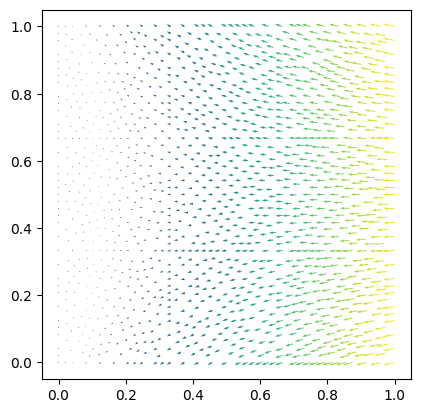

In [ ]:
online_mu = (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0)
reduced_problem.set_mu(online_mu) #Se escoje el nuevo mu para la cual se resuelve el problema
reduced_solution = reduced_problem.solve()
plot(reduced_solution, reduced_problem=reduced_problem)

In [ ]:
reduced_solution.vector()
print(reduced_solution.vector()) #Este debe ser el vector de los coeficientes que multiplican a la base
print(reduced_solution.N) #Tamaño de la solución reducida

[ 0.00807384  1.10604874 -0.03458047]
3


In [ ]:
aux=basis_matrix*reduced_solution.vector()
print(aux)
print("Primer columna")
print(aux[:,0])
print(aux.shape) #Esto no tiene sentido ya que si multiplico la matriz de base reducida por un vector me debería dar un vector, no una matrzi

[[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -0.00000000e+00]
 [ 1.15248272e-04 -3.24963214e-02 -8.27002999e-05]
 ...
 [ 4.36468981e-03  1.91838525e-01 -5.94018019e-03]
 [-4.10687954e-03 -8.63238093e-01  1.14560205e-02]
 [ 4.30906333e-03  2.02354042e-01 -5.74076299e-03]]
Primer columna
[ 0.          0.          0.00011525 ...  0.00436469 -0.00410688
  0.00430906]
(2692, 3)


In [ ]:
vector_de_alfas= np.array(reduced_solution.vector())
solucion= basis_matrix@vector_de_alfas #Solución ahora si sería el valor de los nodos en mi solución
print(solucion)
solucion.shape

[ 0.          0.         -0.03246377 ...  0.19026303 -0.85588895
  0.20092234]


(2692,)

# **Comparar con AGE**

La comparación no esta saliendo del todo bien, porque creo que la función que le asocia el valor a los nodos no es correcta. Ya que en el global los valores generales y el grafico parece tener sentido comparandolo con AGE (difererían en una magnitud de 50 aproximadamente)

Esto debe estar como hacerlo en la función plot de dolfin (FEniCS) ya que el ploteo lo hace bien, pero no esta sencillo de leer

In [ ]:
type(reduced_problem.basis_functions*reduced_solution.vector())

dolfin.function.function.Function

In [ ]:
dolfin.plot??

'\nEste codigo es el que usa el plot de RBniCS para graficar, vemos que da exactamente por lo mismo. Por eso como asociar el nodo al campo debe estar en\nesta función\n'

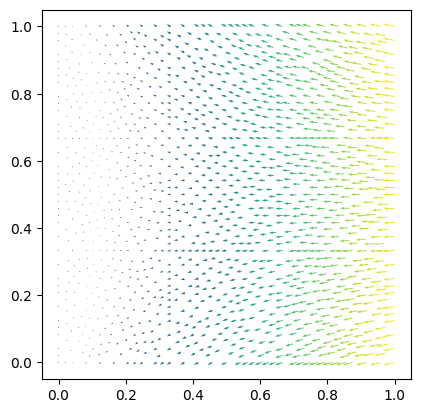

In [ ]:
dolfin.plot(reduced_problem.basis_functions*reduced_solution.vector()) #Esto me da la solución, la pregunta es como hace para graficar y que propiedades tiene este objeto

"""
Este codigo es el que usa el plot de RBniCS para graficar, vemos que da exactamente por lo mismo. Por eso como asociar el nodo al campo debe estar en
esta función
"""

## **Problemas con la función de asociación**

In [ ]:
function= reduced_problem.basis_functions*reduced_solution.vector()
# Obtener el vector
vector = function.vector()

# Índice del dof para el nodo 5, dirección x (en 2D, d=2)
d = V.dim() // V.mesh().num_vertices()  # Número de componentes (2 en 2D)
dof_index_x = 5 * d  # Dirección x (0)

# Valor en ese dof
value_x = vector[dof_index_x]
print(f"Valor en el nodo 5, dirección x: {value_x}")

dof_index_y = 5 * d + 1  # Dirección y (1)
value_y = vector[dof_index_y]
print(f"Valor en el nodo 5, dirección y: {value_y}")

Valor en el nodo 5, dirección x: 0.0
Valor en el nodo 5, dirección y: 0.0


In [ ]:
# Obtener la malla
mesh = function.function_space().mesh()

# Coordenadas de todos los vértices
vertices = mesh.coordinates()

# Coordenadas del nodo 5
node_index = 5
coords = vertices[node_index]
print(f"Coordenadas del nodo {node_index}: {coords}") #Esto no tiene mucho sentido ya que con el output anterior u(0,0)=(1, 0.3333) lo cual no tiene sentido

Coordenadas del nodo 5: [1.         0.33333333]


In [ ]:
# Ejemplo con tu código
vector_de_alfas = np.array(reduced_solution.vector())
solucion = basis_matrix @ vector_de_alfas

# Obtener información de la malla y el espacio
mesh = V.mesh()
vertices = mesh.coordinates()
N_v = mesh.num_vertices()
d = mesh.geometry().dim()
dof_coordinates = V.tabulate_dof_coordinates()

# Imprimir correspondencia
for i in range(min(10000, n_dofs)):  # Limitar a 10 para no saturar la salida
    vertex_idx = i // d
    direction = i % d
    coord = dof_coordinates[i]
    value = solucion[i]
    print(f"Dof {i}: Vértice {vertex_idx} en {coord}, Dirección {direction}, Valor {value}")

Dof 0: Vértice 0 en [0. 0.], Dirección 0, Valor 0.0
Dof 1: Vértice 0 en [0. 0.], Dirección 1, Valor 0.0
Dof 2: Vértice 1 en [0.02083333 0.        ], Dirección 0, Valor -0.03246377342931433
Dof 3: Vértice 1 en [0.02083333 0.        ], Dirección 1, Valor -0.0310163708630586
Dof 4: Vértice 2 en [0.         0.02083333], Dirección 0, Valor 0.0
Dof 5: Vértice 2 en [0.         0.02083333], Dirección 1, Valor 0.0
Dof 6: Vértice 3 en [0.04166667 0.        ], Dirección 0, Valor -0.05840332883026454
Dof 7: Vértice 3 en [0.04166667 0.        ], Dirección 1, Valor -0.05461665962351585
Dof 8: Vértice 4 en [0.03645833 0.03645833], Dirección 0, Valor -0.0348445687184318
Dof 9: Vértice 4 en [0.03645833 0.03645833], Dirección 1, Valor -0.03495846852450982
Dof 10: Vértice 5 en [0.         0.04166667], Dirección 0, Valor 0.0
Dof 11: Vértice 5 en [0.         0.04166667], Dirección 1, Valor 0.0
Dof 12: Vértice 6 en [0.07291667 0.03125   ], Dirección 0, Valor -0.07498128844882733
Dof 13: Vértice 6 en [0.0729

In [ ]:
import numpy as np
from dolfin import *

# Ejemplo con tu código
vector_de_alfas = np.array(reduced_solution.vector())
solucion = basis_matrix @ vector_de_alfas

# Obtener información de la malla y el espacio
mesh = V.mesh()
vertices = mesh.coordinates()
N_v = mesh.num_vertices()
d = mesh.geometry().dim()
n_dofs = V.dim()  # Número total de grados de libertad
dof_coordinates = V.tabulate_dof_coordinates()

# Crear una lista para almacenar los datos de cada vértice
vertex_data = []

# Recolectar datos de vértices
for vertex_idx in range(N_v):
    # Dofs para dirección x (0) y y (1)
    dof_x = vertex_idx * d      # Dirección 0 (x)
    dof_y = vertex_idx * d + 1  # Dirección 1 (y)

    # Coordenadas del vértice
    coord = vertices[vertex_idx]
    x_coord = coord[0]

    # Valores en dirección x e y
    value_x = solucion[dof_x]
    value_y = solucion[dof_y]

    # Almacenar en una tupla: (x_coord, vertex_idx, coord, value_x, value_y)
    vertex_data.append((x_coord, vertex_idx, coord, value_x, value_y))

# Ordenar por coordenada x (primer elemento de la tupla)
vertex_data_sorted = sorted(vertex_data, key=lambda x: x[0])

# Imprimir correspondencia ordenada
print("Valores ordenados por coordenada X del vértice:")
for i, (x_coord, vertex_idx, coord, value_x, value_y) in enumerate(vertex_data_sorted):
    if i >= 10000:  # Limitar a 10000 para no saturar la salida
        break
    print(f"Vértice {vertex_idx}: Coordenada {coord}, Valor X = {value_x:.6f}, Valor Y = {value_y:.6f}")


Valores ordenados por coordenada X del vértice:
Vértice 12: Coordenada [0. 1.], Valor X = -0.078967, Valor Y = -0.067257
Vértice 13: Coordenada [0.         0.66666667], Valor X = -0.083030, Valor Y = -0.067203
Vértice 14: Coordenada [0.         0.33333333], Valor X = -0.061327, Valor Y = -0.049854
Vértice 15: Coordenada [0. 0.], Valor X = -0.030013, Valor Y = -0.025135
Vértice 21: Coordenada [0.         0.83333333], Valor X = -0.087999, Valor Y = -0.066198
Vértice 26: Coordenada [0.         0.16666667], Valor X = -0.126236, Valor Y = -0.101555
Vértice 37: Coordenada [0.  0.5], Valor X = -0.053259, Valor Y = -0.037067
Vértice 56: Coordenada [0.         0.08333333], Valor X = -0.116547, Valor Y = -0.060882
Vértice 69: Coordenada [0.   0.75], Valor X = -0.162987, Valor Y = -0.084454
Vértice 72: Coordenada [0.         0.91666667], Valor X = -0.109870, Valor Y = -0.052217
Vértice 117: Coordenada [0.         0.41666667], Valor X = -0.044496, Valor Y = -0.014998
Vértice 123: Coordenada [0.   

In [ ]:
# Listas para almacenar los puntos que cumplen la condición
points_x = []  # Para dirección x
points_y = []  # Para dirección y

# Buscar puntos con valores entre 0 y 0.01
for vertex_idx in range(N_v):
    # Dofs para dirección x (0) y y (1)
    dof_x = vertex_idx * d      # Dirección 0 (x)
    dof_y = vertex_idx * d + 1  # Dirección 1 (y)

    # Coordenadas del vértice
    coord = vertices[vertex_idx]

    # Valores en dirección x e y
    value_x = solucion[dof_x]
    value_y = solucion[dof_y]

    # Verificar si el valor está entre 0 y 0.01
    if 0 <= value_x <= 0.01:
        points_x.append((vertex_idx, coord, value_x))
    if 0 <= value_y <= 0.01:
        points_y.append((vertex_idx, coord, value_y))

# Imprimir resultados
print("\nPuntos con valor en dirección X entre 0 y 0.01:")
for vertex_idx, coord, value in points_x:
    print(f"Vértice {vertex_idx}: Coordenada {coord}, Valor X = {value:.6f}")

print("\nPuntos con valor en dirección Y entre 0 y 0.01:")
for vertex_idx, coord, value in points_y:
    print(f"Vértice {vertex_idx}: Coordenada {coord}, Valor Y = {value:.6f}")


Puntos con valor en dirección X entre 0 y 0.01:
Vértice 0: Coordenada [0.66666667 1.        ], Valor X = 0.000000
Vértice 2: Coordenada [1.         0.66666667], Valor X = 0.000000
Vértice 5: Coordenada [1.         0.33333333], Valor X = 0.000000
Vértice 9: Coordenada [0.33333333 0.66666667], Valor X = 0.000000
Vértice 16: Coordenada [0.83333333 0.66666667], Valor X = 0.000000
Vértice 25: Coordenada [0.16666667 0.33333333], Valor X = 0.000000
Vértice 40: Coordenada [0.83333333 0.83333333], Valor X = 0.000000
Vértice 49: Coordenada [0.91666667 0.        ], Valor X = 0.000000
Vértice 62: Coordenada [0.33333333 0.08333333], Valor X = 0.000000
Vértice 77: Coordenada [0.75 0.75], Valor X = 0.000000
Vértice 100: Coordenada [0.43055556 0.90277778], Valor X = 0.000000
Vértice 120: Coordenada [0.08333333 0.15625   ], Valor X = 0.000000
Vértice 143: Coordenada [0.75 1.  ], Valor X = 0.000000
Vértice 172: Coordenada [0.72916667 0.27083333], Valor X = 0.000000
Vértice 191: Coordenada [0.70833333 0

# **ESTE CREO QUE ANDA BIEN!!!!!**

In [ ]:
function= reduced_problem.basis_functions*reduced_solution.vector()

# Obtener el vector, espacio y malla
vector = function.vector()
V = function.function_space()
mesh = V.mesh()
vertices = mesh.coordinates()
N_v = mesh.num_vertices()
d = mesh.geometry().dim()  # 2 en 2D

# Obtener el dofmap y las coordenadas de los dofs
dofmap = V.dofmap()
dof_coordinates = V.tabulate_dof_coordinates()  # Coordenadas asociadas a cada dof

# Número de componentes (2 en 2D)
num_components = V.ufl_element().value_size()  # 2 para vectorial 2D

# Mapear dofs a vértices para cada componente
for vertex_idx in range(N_v):
    # Obtener los dofs asociados al vértice (puede haber más de uno por componente)
    dofs = dofmap.tabulate_local_to_global_dofs()  # Todos los dofs globales
    vertex_dofs = dofmap.entity_dofs(mesh, 0, [vertex_idx])  # 0 = vértices

    # Coordenadas del vértice
    coord = vertices[vertex_idx]

    # Extraer valores para cada componente
    if len(vertex_dofs) == num_components:  # Debería ser 2 en 2D vectorial
        value_x = vector[vertex_dofs[0]]  # Dirección x
        value_y = vector[vertex_dofs[1]]  # Dirección y
        if coord[0]==0: #Esto se saca después
          print(f"Vértice {vertex_idx}: Coordenada {coord}, Valor X = {value_x:.6f}, Valor Y = {value_y:.6f}")
    else:
        print(f"Vértice {vertex_idx}: No se encontraron todos los dofs esperados.")

# Verificar con las coordenadas de los dofs
print("\nCoordenadas de los dofs y valores:")
for i in range(min(100, V.dim())):  # Limitar a 10 para no saturar
    coord = dof_coordinates[i]
    value = vector[i]
    direction = i % num_components
    print(f"Dof {i}: Coordenada {coord}, Dirección {direction}, Valor = {value:.6f}")

Vértice 12: Coordenada [0. 1.], Valor X = 0.000000, Valor Y = 0.000000
Vértice 13: Coordenada [0.         0.66666667], Valor X = 0.000000, Valor Y = 0.000000
Vértice 14: Coordenada [0.         0.33333333], Valor X = 0.000000, Valor Y = 0.000000
Vértice 15: Coordenada [0. 0.], Valor X = 0.000000, Valor Y = 0.000000
Vértice 21: Coordenada [0.         0.83333333], Valor X = 0.000000, Valor Y = 0.000000
Vértice 26: Coordenada [0.         0.16666667], Valor X = 0.000000, Valor Y = 0.000000
Vértice 37: Coordenada [0.  0.5], Valor X = 0.000000, Valor Y = 0.000000
Vértice 56: Coordenada [0.         0.08333333], Valor X = 0.000000, Valor Y = 0.000000
Vértice 69: Coordenada [0.   0.75], Valor X = 0.000000, Valor Y = 0.000000
Vértice 72: Coordenada [0.         0.91666667], Valor X = 0.000000, Valor Y = 0.000000
Vértice 117: Coordenada [0.         0.41666667], Valor X = 0.000000, Valor Y = 0.000000
Vértice 123: Coordenada [0.   0.25], Valor X = 0.000000, Valor Y = 0.000000
Vértice 139: Coordenada 

In [ ]:
import pandas as pd
# Listas para almacenar los datos
vertex_indices = []
coords_x = []
coords_y = []
values_x = []
values_y = []

# Mapear dofs a vértices para cada componente
for vertex_idx in range(N_v):
    # Obtener los dofs asociados al vértice
    vertex_dofs = dofmap.entity_dofs(mesh, 0, [vertex_idx])  # 0 = vértices

    # Coordenadas del vértice
    coord = vertices[vertex_idx]

    # Extraer valores para cada componente
    if len(vertex_dofs) == num_components:  # Debería ser 2 en 2D vectorial
        value_x = vector[vertex_dofs[0]]  # Dirección x
        value_y = vector[vertex_dofs[1]]  # Dirección y
        vertex_indices.append(vertex_idx)
        coords_x.append(coord[0])
        coords_y.append(coord[1])
        values_x.append(value_x)
        values_y.append(value_y)

# Seleccionar 20 índices al azar
n_total = len(vertex_indices)
n_values = min(20, n_total)  # Asegurarse de no exceder el número total de nodos
random_indices = np.random.choice(n_total, size=n_values, replace=False)

# Crear un DataFrame con los datos aleatorios
data = {
    'Índice del Vértice': [vertex_indices[i] for i in random_indices],
    'Coordenada X': [coords_x[i] for i in random_indices],
    'Coordenada Y': [coords_y[i] for i in random_indices],
    'Valor X': [values_x[i] for i in random_indices],
    'Valor Y': [values_y[i] for i in random_indices]
}
df = pd.DataFrame(data)

# Exportar a Excel
output_file = 'valores_nodos.xlsx'
df.to_excel(output_file, index=False)
print(f"Se han exportado {n_values} valores de nodos a '{output_file}'")

Se han exportado 20 valores de nodos a 'valores_nodos.xlsx'


In [ ]:
# Descargar el archivo en Colab
from google.colab import files
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Datos estadisticos del comportamiento de u**

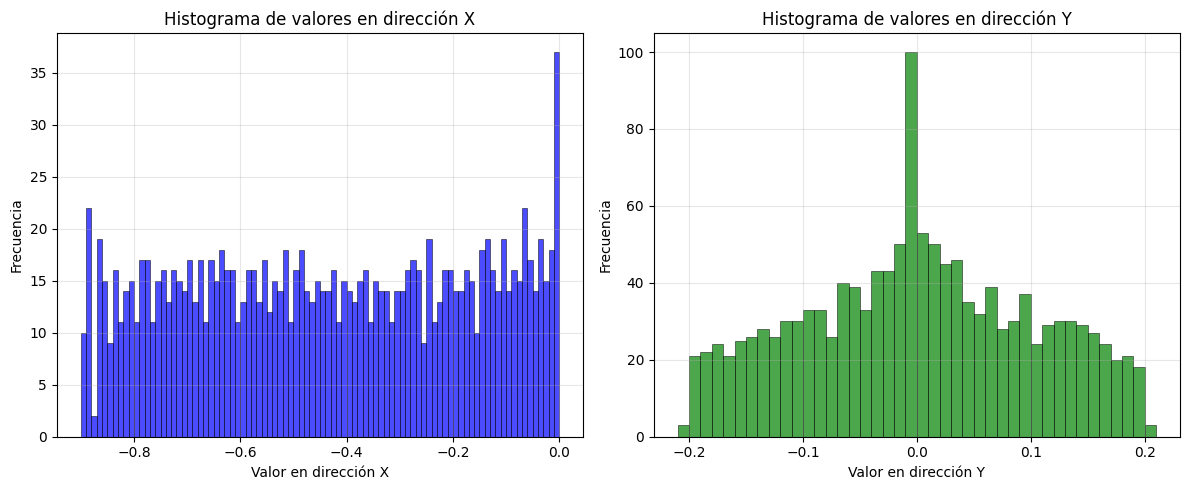

Histogramas guardados como 'histogram_values_xy.png'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:

import matplotlib.pyplot as plt


# Ejemplo con tu código
vector_de_alfas = np.array(reduced_solution.vector())
solucion = basis_matrix @ vector_de_alfas

# Obtener información de la malla y el espacio
mesh = V.mesh()
vertices = mesh.coordinates()
N_v = mesh.num_vertices()
d = mesh.geometry().dim()
n_dofs = V.dim()  # Número total de grados de libertad
dof_coordinates = V.tabulate_dof_coordinates()

# Extraer valores en las direcciones x (direction = 0) y y (direction = 1)
values_x = []
values_y = []
for i in range(n_dofs):
    direction = i % d
    value = solucion[i]
    if direction == 0:  # Dirección x
        values_x.append(value)
    elif direction == 1:  # Dirección y
        values_y.append(value)

# Convertir a arrays de NumPy
values_x = np.array(values_x)
values_y = np.array(values_y)

# Definir los bins con separación de 0.01 para ambos
bin_width = 0.01
min_val_x = np.floor(values_x.min() / bin_width) * bin_width
max_val_x = np.ceil(values_x.max() / bin_width) * bin_width
bins_x = np.arange(min_val_x, max_val_x + bin_width, bin_width)

min_val_y = np.floor(values_y.min() / bin_width) * bin_width
max_val_y = np.ceil(values_y.max() / bin_width) * bin_width
bins_y = np.arange(min_val_y, max_val_y + bin_width, bin_width)

# Crear figura con dos subgráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histograma para dirección x
ax1.hist(values_x, bins=bins_x, edgecolor='black', linewidth=0.5, color='blue', alpha=0.7)
ax1.set_title('Histograma de valores en dirección X')
ax1.set_xlabel('Valor en dirección X')
ax1.set_ylabel('Frecuencia')
ax1.grid(True, alpha=0.3)

# Histograma para dirección y
ax2.hist(values_y, bins=bins_y, edgecolor='black', linewidth=0.5, color='green', alpha=0.7)
ax2.set_title('Histograma de valores en dirección Y')
ax2.set_xlabel('Valor en dirección Y')
ax2.set_ylabel('Frecuencia')
ax2.grid(True, alpha=0.3)

# Ajustar el diseño para evitar solapamiento
plt.tight_layout()

# Mostrar los histogramas
plt.show()

# Opcional: Guardar la figura como imagen
plt.savefig('histogram_values_xy.png', dpi=300, bbox_inches='tight')
print("Histogramas guardados como 'histogram_values_xy.png'")

# Descargar en Colab (opcional)
from google.colab import files
files.download('histogram_values_xy.png')

# *Mallado*

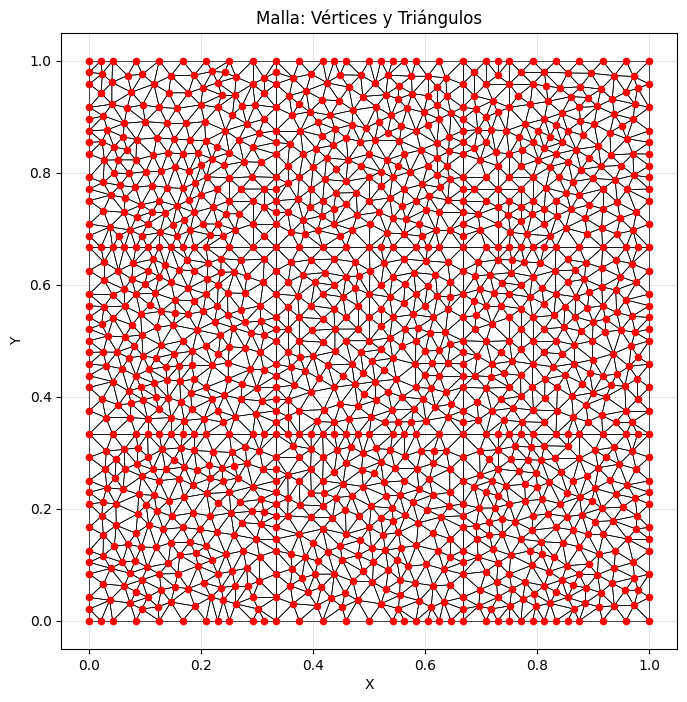

In [ ]:
# Obtener información de la malla y el espacio
mesh = V.mesh()
vertices = mesh.coordinates()  # Coordenadas de los vértices (N_v x 2)
N_v = mesh.num_vertices()
d = mesh.geometry().dim()
n_dofs = V.dim()

# Verificar que sea 2D
assert d == 2, "Este código asume una malla 2D"

# Obtener los triángulos (celdas de la malla)
cells = mesh.cells()  # Índices de los vértices que forman cada triángulo (N_cells x 3)

# Crear la figura
plt.figure(figsize=(8, 8))

# Graficar los triángulos
for cell in cells:
    # Coordenadas de los 3 vértices del triángulo
    v0 = vertices[cell[0]]
    v1 = vertices[cell[1]]
    v2 = vertices[cell[2]]

    # Dibujar las líneas que conectan los vértices (cerrando el triángulo)
    plt.plot([v0[0], v1[0]], [v0[1], v1[1]], 'k-', linewidth=0.5)  # Lado 0-1
    plt.plot([v1[0], v2[0]], [v1[1], v2[1]], 'k-', linewidth=0.5)  # Lado 1-2
    plt.plot([v2[0], v0[0]], [v2[1], v0[1]], 'k-', linewidth=0.5)  # Lado 2-0

# Graficar los vértices como puntos
plt.scatter(vertices[:, 0], vertices[:, 1], c='red', s=20, zorder=5)  # Puntos rojos sobre los triángulos

# Configurar el gráfico
plt.title('Malla: Vértices y Triángulos')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal')  # Mantener proporciones iguales
plt.grid(True, alpha=0.3)

# Mostrar el gráfico
plt.show()

### 4.7. Perform an error analysis

In [ ]:
reduction_method.initialize_testing_set(120) #Este testo no se como lo hace
reduction_method.error_analysis()

=          ElasticBlock POD-Galerkin error analysis begins           =

################################# 0 ##################################
################################# 1 ##################################
################################# 2 ##################################
################################# 3 ##################################
################################# 4 ##################################
################################# 5 ##################################
################################# 6 ##################################
################################# 7 ##################################
################################# 8 ##################################
################################# 9 ##################################
################################# 10 #################################
################################# 11 #################################
################################# 12 #################################
#####

### 4.8. Perform a speedup analysis

In [ ]:
reduction_method.initialize_testing_set(140)
reduction_method.speedup_analysis()

=         ElasticBlock POD-Galerkin speedup analysis begins          =

################################# 0 ##################################
################################# 1 ##################################
################################# 2 ##################################
################################# 3 ##################################
################################# 4 ##################################
################################# 5 ##################################
################################# 6 ##################################
################################# 7 ##################################
################################# 8 ##################################
################################# 9 ##################################
################################# 10 #################################
################################# 11 #################################
################################# 12 #################################
#####

## 5. Assignments
1. Consider now the simplified problem in which
$$
\mu_0 \equiv \mu_1 \equiv \mu_2 \quad \text{and} \quad \mu_3 \equiv \mu_4 \equiv \mu_5 \quad \text{and} \quad
\mu_6 \equiv \mu_7 = 1 \quad \text{and} \quad \mu_8 \equiv \mu_9 \equiv \mu_{10}
$$
Denote by $\boldsymbol{\eta} = (\mu_0, \mu_3, \mu_8)$ the parameter vector of the simplified problem, defined on the parameter domain $\mathbb{Q}=[1,100]^2\times[-1,1]$.
Implement the simplified problem in a copy of this notebook. What do you observe for what concerns the POD eigenvalue, error analysis, speedup analysis? _Suggestion: for every new notebook copy change the value returned by the name() method of the ElasticBlock class to avoid conflicts between this notebook and your copy_.

2. Create another copy of this notebook, and change the model reduction technique from POD-Galerkin to certified reduced basis. You may need to add a new method in the ElasticBlock class which is currently missing. Compare the results of the error analysis and speedup analysis for the two reduction techniques.
